In [53]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd

In [94]:
def scrapeWaterLevel(station_id, start_date, end_date, time_interval=20):
    """
    水文水質データベースから指定の水位観測局にから指定期間のデータをスクレイオイングする
    水文水質データベースURL: http://www1.river.go.jp/
    Args:
        sation_id  (int): 観測局のID 
        start_date　　　 : 取得開始日時 (形式はYY/mm/dd)
        end_date　　　   : 取得終了日時 (形式はYY/mm/dd)
    Returns:
        df_river (pandas.dataFrame): スクレイピングしたデータのDataFrame
    """
    # URLのベースを宣言 (ID, 開始日時, 終了日時を指定できる様にする)
    url = 'http://www1.river.go.jp/cgi-bin/DspWaterData.exe?KIND=1&ID={0}&BGNDATE={1}&ENDDATE={2}&KAWABOU=NO'
    # 日時配列の生成
    date_list = fetchDateList(start_date, end_date, time_interval=20)
    # 日時配列でループ
    wl_data_list = []
    for date in date_list:
        begin, end = date[0], date[1]
        url_tmp = url.format(station_id, begin, end)
        wl_data = subtractWlData(url_tmp)
        # データが存在しない場合には次のループへ
        if wl_data is None:
            continue
        wl_data_list += wl_data
    # 配列をDataFrameに変換
    df_wl = list2dataframe(wl_data_list)
    return df_wl

In [7]:
import datetime

def fetchDateList(start_date, end_date, time_interval=20):
    """
    水文水質データベースからデータを取得するための開始時刻と終了後に時刻の配列を作成。
    time_intervalで指定された時間間隔で配列を生成する
    Args:
        start_date　　　 : 取得開始日時 (形式はYY/mm/dd)
        end_date　　　   : 取得終了日時 (形式はYY/mm/dd)
    Returns:
        date_list (list): 取得対象期間の配列
    """
    # String形式の日時をdatetimeに変換
    start_datetime = datetime.datetime.strptime(start_date, "%Y/%m/%d")
    end_datetime = datetime.datetime.strptime(end_date, "%Y/%m/%d")
    
    end_flag = False
    proceeded_date = 0
    date_list = []
    
    while(not end_flag):
        # データの取得開始時間と終了後時間を生成
        search_bgn_datetime = start_datetime + datetime.timedelta(days=proceeded_date)
        search_end_datetime = start_datetime + datetime.timedelta(days=proceeded_date + time_interval -1)
        # time_interval分の余地がない場合にend_flagをTrueに設定し次回ループに突入しない様にする
        if search_end_datetime >= end_datetime:
            search_end_datetime = end_datetime
            end_flag = True
        proceeded_date += time_interval
        date_list.append([search_bgn_datetime.strftime("%Y%m%d"), search_end_datetime.strftime("%Y%m%d")])
    
    return date_list

In [42]:
def subtractWlData(url):
    """
    指定URLから水位データを抽出し配列を返す。
    Args:
        url (String): データ取得する先のURL
    Returns:
        wl_data_list (list): 水位データの配列
    """
    try: 
        # Driverの生成とURLで指定のページを操作を行う
        driver = createDriver()
        driver.get(url)
        # 水位データを取得するためにifrmaを取得
        iframe = driver.find_element_by_tag_name('iframe')
        driver.switch_to.frame(iframe)
        # iframeのソースを取得し表データの'tr'タグを全て取得する
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        table = soup.findAll("table")[0]
        rows = table.findAll("tr")
        driver.close()
    except:
        return None
    
    # tableから水位データの配列を生成
    wl_data_list = []
    for row in rows:
        list_tmp = []
        td_list = row.findAll(['td'])
        for td in td_list:
            list_tmp.append(td.get_text().replace('\u3000', ''))
        wl_data_list.append(list_tmp)
    
    return wl_data_list

In [22]:
def createDriver():
    """
    Seleniumでブラウザ操作を行うためのドライバを生成する
    Args:
        None
    Returns:
        driver (selenium.webdriver.remote.webdriver.WebDriver):
            SeleniumでChromeを操作するためのドライバ
    """
    # Chrome のオプションを設定する
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')

    # Selenium Server に接続する
    driver = webdriver.Remote(
        command_executor='http://localhost:4444/wd/hub',
        desired_capabilities=options.to_capabilities(),
        options=options)
    
    return driver

In [98]:
def list2dataframe(wl_list):
    """
    スクレイピングで取得してした配列をDataFrameに変換する
    Args:
        wl_list (list): 取得した水位データの配列。[日付, 時間, 水位]の項目順を前提としている。
    Returns:
        df_wl (pandas.DataFrame): 配列をDataFrameへの変換後の水位データ
    """
    # 配列をPandasに変換し日付と時刻を結合する
    df_wl = pd.DataFrame(wl_list,columns=['date', 'time', 'water_lev'])
    df_wl.loc[:,'date'] = df_wl.loc[:,'date'] + ' ' + df_wl.loc[:,'time']
    df_wl.drop('time', axis=1, inplace=True)
    df_wl.dropna(how='all', inplace=True)
    
    # 'time'をdatetime型に'水位'をfloat型に変換する
    df_wl['date'] = df_wl['date'].astype('str').apply(str2datetime)
    df_wl['water_lev'] = pd.to_numeric(df_wl['water_lev'], errors='coerce')
    df_wl.set_index('date', inplace=True)
    df_wl.sort_index(inplace=True)
    
    return df_wl

In [90]:
def str2datetime(string):
    """
    Stringの日時データをdatetime型に変換する。
    'YYYY/MM/DD 24:00'表記の日時を'YYYY/MM/DD+1 00:00'に変換する。
    Args:
        string (String): 日時の文字列。'YYYY/MM/DD HH:mm'の表記を前提とする。
    Returns:
        date (datetime.datetime): 日時のdatetime変換後の形式
    """
    if string[-5:] == '24:00':
        string = string[:-5] + ' ' + '00:00'
        date = datetime.datetime.strptime(string, "%Y/%m/%d %H:%M")
        date += datetime.timedelta(days=1)
    else:
        date = datetime.datetime.strptime(string, "%Y/%m/%d %H:%M")
    return date

In [105]:
# データの取得
start_date_test = '1990/01/01'
end_date_test = '2020/01/01'
station_id = 303051283310020

wl_data_list_test = scrapeWaterLevel(station_id, start_date_test, end_date_test)

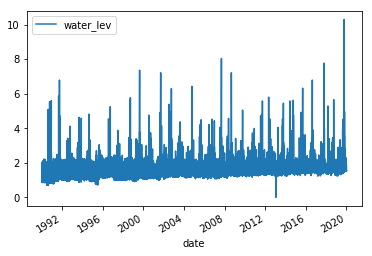

In [106]:
wl_data_list_test.plot()

In [107]:
wl_data_list_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260832 entries, 1990-01-01 01:00:00 to 2020-01-02 00:00:00
Data columns (total 1 columns):
water_lev    260153 non-null float64
dtypes: float64(1)
memory usage: 4.0 MB
